In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
#%matplotlib inline
from astropy.io import fits
from astropy.table import Table
from astropy.modeling import models, fitting
#from prompt_toolkit.input.win32 import Vt100ConsoleInputReader
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from scipy.integrate import simpson
import os
import pandas as pd

from DataManager import DataManager

In [3]:
#Consts
#ROOT = os.path.dirname(os.path.realpath(__file__))
ROOT = os.getcwd()
M81 = ROOT+'/data/M81/'
NGC2281 = ROOT+'/data/NGC2281/'

#Get Data
'''
Object Structure of return from DataManager.retrieve():
{'Flat_V': []
,'Flat_R': []
,'Flat_B': []
,'Light_V': []
,'Light_R': []
,'Light_B': []
,'Dark': []
,'Bias': []
}
'''
DM = DataManager()

DM.fetchData(NGC2281)
NGC2281 = DM.retrieve()
DM.clear()

## Exposure Times of NGC2281

- **Light (v/r)**: 5 s
- **Light (b)**: 10 s
- **Dark**: 30 s
- **Bias**: 0 s
- **Flat (b)**: 4 s
- **Flat (r)**: 3.5 s
- **Flat (v)**: 4 s

In [4]:
# Defining the frames, aka here are all the masterframes for each of the pictures.
flat_v = NGC2281["Flat_V"]
flat_r = NGC2281["Flat_R"]
flat_b = NGC2281["Flat_B"]
light_v = NGC2281["Light_V"]
light_r = NGC2281["Light_R"]
light_b = NGC2281["Light_B"]
dark = NGC2281["Dark"]
bias = NGC2281["Bias"]
# exposure times:
exposure_time_dark = 30
exposure_time_flat_b = 4
exposure_time_flat_v = 4
exposure_time_flat_r = 3.5
exposure_time_light_b = 10
exposure_time_light_v = 5
exposure_time_light_r = 5

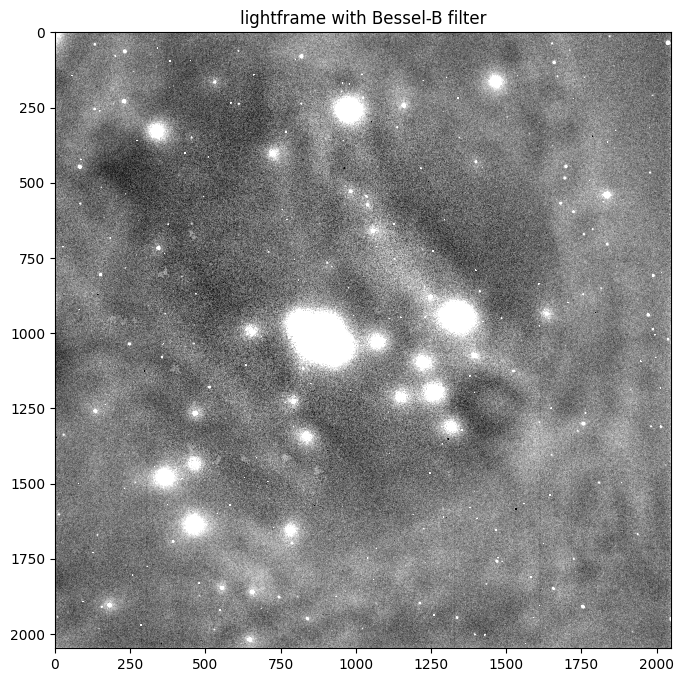

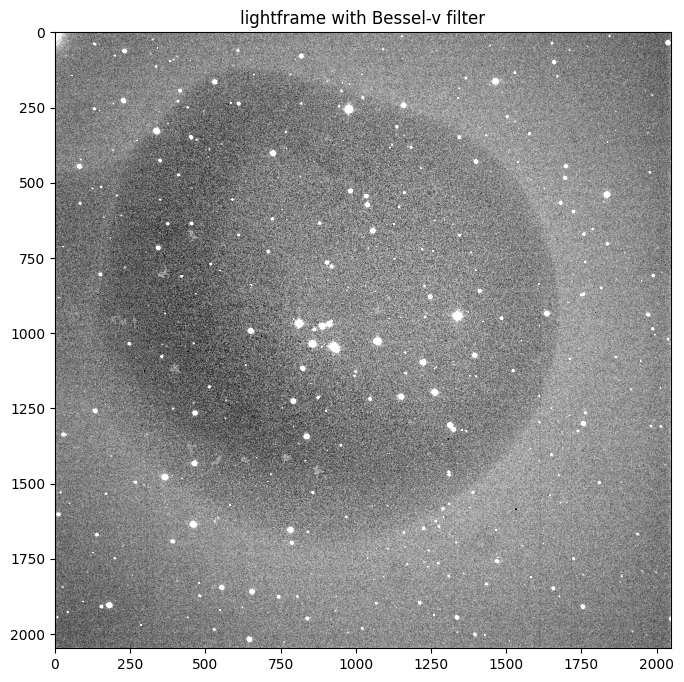

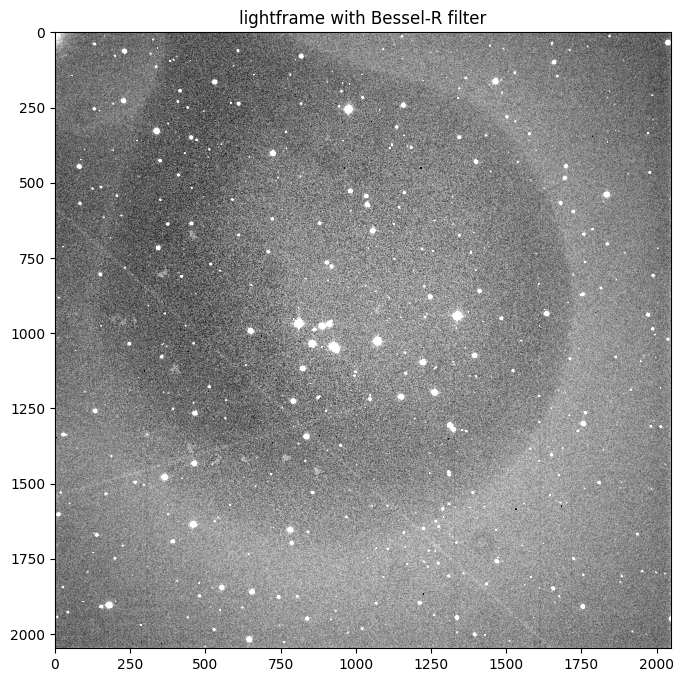

In [ ]:
%matplotlib inline
# Correction of the scienceframes: TODO: Check how the exposure time should be done
# HEREEEEEEE I am doing the (hopefully) correct Data Reduction:

# first, remove the Bias from the Dark and scale the Dark down to 1 sek.:
master_dark_1_sek = (dark - bias) / exposure_time_dark

# now lets correct the flats for their respective filters and axposure times:
# for that, just multiply the down scaled dark y the respective exposure times,
# as a last step normalise the flat by dividing by the max(flat):

master_flat_b = ((flat_b - bias) - (master_dark_1_sek * exposure_time_flat_b))
master_flat_b = master_flat_b / np.max(master_flat_b)

master_flat_v = ((flat_v - bias) - (master_dark_1_sek * exposure_time_flat_v))
master_flat_v = master_flat_v / np.max(master_flat_v)

master_flat_r = ((flat_r - bias) - (master_dark_1_sek * exposure_time_flat_r))
master_flat_r = master_flat_r / np.max(master_flat_r)

# now pretty much the same for the light framse:

master_light_b = ((light_b - bias) - (master_dark_1_sek * exposure_time_light_b))
corrected_light_b = master_light_b / np.max(master_light_b)

master_light_v = ((light_v - bias) - (master_dark_1_sek * exposure_time_light_v))
corrected_light_v = master_light_v / np.max(master_light_v)

master_light_r = ((light_r - bias) - (master_dark_1_sek * exposure_time_light_r))
corrected_light_r = master_light_r / np.max(master_light_r)


# Plotting the three images:
fig = plt.figure(figsize=(8,8))
plt.title("lightframe with Bessel-B filter")
plt.imshow(corrected_light_b, cmap = 'gray', vmin = np.percentile(corrected_light_b, 5), vmax = np.percentile(corrected_light_b, 95))
plt.show()

fig = plt.figure(figsize=(8,8))
plt.title("lightframe with Bessel-v filter")
plt.imshow(corrected_light_v, cmap = 'gray', vmin = np.percentile(corrected_light_v, 5), vmax = np.percentile(corrected_light_v, 95))
plt.show()

fig = plt.figure(figsize=(8,8))
plt.title("lightframe with Bessel-R filter")
plt.imshow(corrected_light_r, cmap = 'gray', vmin = np.percentile(corrected_light_r, 5), vmax = np.percentile(corrected_light_r, 95))
plt.show()
 


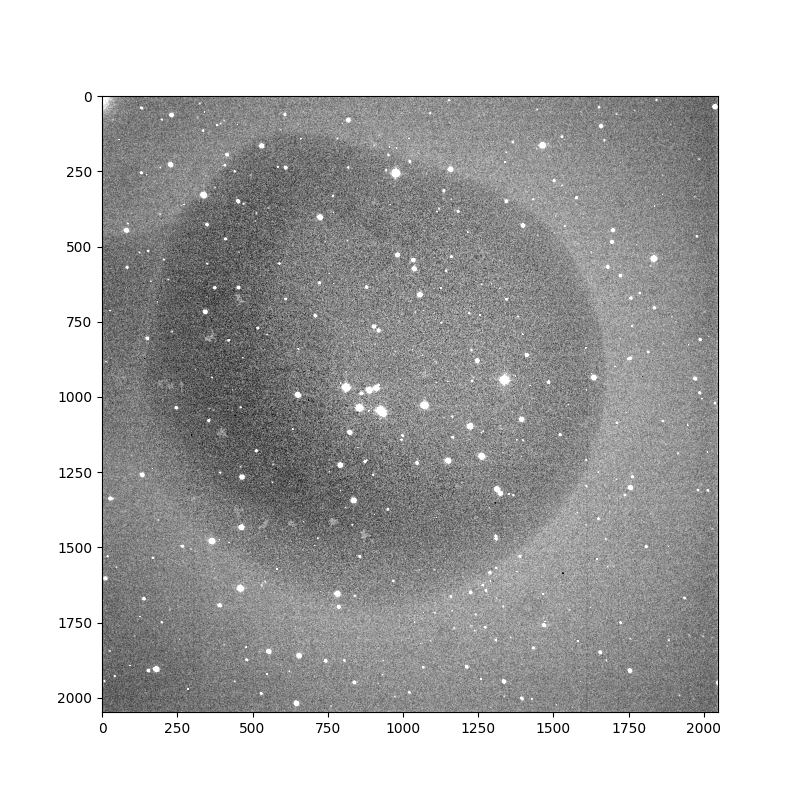

(2048, 2048) -0.03148527790439451 1.0


In [6]:
#%matplotlib notebook
%matplotlib widget
#%matplotlib inline
# This is needed to allow interactivity and showing the position of the mouse to find the stars.

fig = plt.figure(figsize=(8,8))
plt.imshow(corrected_light_v, cmap = 'gray', vmin = np.percentile(corrected_light_v, 5), vmax = np.percentile(corrected_light_v, 95))
plt.show()
print(corrected_light_v.shape, np.min(corrected_light_v), np.max(corrected_light_v))

In [ ]:
#Visualization
def plot_marked_stars(image, centers, radii):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image, cmap = 'gray', vmin = np.percentile(image, 5), vmax = np.percentile(image, 95))
    
    # Overlay circular patches
    for i, (center, radius) in enumerate(zip(centers, radii)):
        circle = Circle(center, radius, color='red', fill=False, linewidth=0.5)
        ax.add_patch(circle)
        ax.text(center[0]+radius, center[1]+radius, f"{i}.", color='yellow', fontsize=10, ha='left', va='bottom', 
                bbox=dict(facecolor='black', alpha=0.1, edgecolor='none'))
    
    ax.set_title("Selected Stars")
    plt.show()

#Circle midpoints (x, y)
centers = [(930, 1050)
           ,(1072, 1027)
           ,(1336, 944)
           ]

#Circle sizes
radii = [30
         ,22
         ,20
         ]


plot_marked_stars(corrected_light_v, centers, radii)

fluxes = DM.circularSelection(corrected_light_v, centers, radii)
print(fluxes)

